# Определение перспективного тарифа для телеком-компании

Нам предоставлены данные 500 пользователей федерального оператора сотовой связи. 

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нужно проанализировать поведение пользователей и сделать вывод, какой из тарифов лучше.

### Описание тарифов

**Тариф «Смарт»**

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей
    
**Примечание**

Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.    

## Изучение общей информации

In [1]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
from scipy import stats as st
import numpy as np

# чтение файла со звонками
calls = pd.read_csv('/datasets/calls.csv')
calls.head(5)


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [2]:
# просмотр общей информации о файле
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
# чтение файла с информацией об интернет-сессиях
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
internet.head(5)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [4]:
# просмотр общей информации о файле
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
# чтение файла с информацией о сообщениях
messages = pd.read_csv('/datasets/messages.csv')
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
# просмотр общей информации о файле
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
# чтение файла с информацией о тарифах
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
# чтение файла с информацией о пользователях
users = pd.read_csv('/datasets/users.csv')
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [9]:
# просмотр общей информации о файле
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В ходе изучения общей информации были выявлены проблемы - не подходящие типы данных, поэтому необходимо:

В таблице calls:
- изменить тип данных в столбце call_date на datetime

В таблице internet:
- изменить тип данных в столбце session_date на datetime

В таблице messages:
- изменить тип данных в столбце message_date на datetime


## Подготовка данных

### Замена типов данных

In [10]:
# перевод данных в формат дат
# создаем список столбцов для преобразования
data_list = [calls, internet, messages]
column_list = ['call_date', 'session_date', 'message_date']
# циклом меняем формат на datetime и создаем столбец с месяцем
for i in data_list:
    for a in column_list:
        if a in i.columns:
            i[a] = pd.to_datetime(i[a], format='%Y-%m-%d %H:%M')
            i['month'] = i[a].dt.month
   
  

In [11]:
# переименование столбца с названиями тарифов в таблице tariff, чтобы можно было в дальнейшем мерджить еe с общим фреймом
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [12]:
# посмотрим на диапазон продолжительности звонков
print(calls['duration'].min())
print(calls['duration'].max())

0.0
38.0


In [13]:
# подсчет количества нулевых звонков
calls.query('duration ==0')['duration'].count()

39613

In [14]:
# посмотрим на диапазон объема интернет-трафика
print(internet['mb_used'].min())
print(internet['mb_used'].max())

0.0
1724.83


In [15]:
# подсчет количества сессий с нулевым трафиком
internet.query('mb_used ==0')['mb_used'].count()

19598

In [16]:
calls['duration'] = np.ceil(calls['duration'])


### Подготовка пользовательских данных

In [17]:
# расчет количества сделанных звонков и израсходованных минут разговора по месяцам
calls_grouped = calls.groupby(['user_id', 'month']).agg({'user_id': 'count','duration': 'sum'}).rename(columns = {'user_id': 'calls'}).reset_index()
calls_grouped.head(5)

,user_id,month,calls,duration
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


In [18]:
# расчет количества отправленных сообщений по месяцам
messages_grouped = messages.groupby(['user_id', 'month']).agg({'id':'count'}).rename(columns={'id':'messages'}).reset_index()
messages_grouped.head(5)

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [19]:
# расчет объема израсходованного интернет-трафика по месяцам
internet_grouped = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet_grouped.head(5)

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [20]:
# объединим таблицы для дальнейших вычислений
data = calls_grouped.merge(messages_grouped, on=['user_id','month'], how='outer')
data = data.merge(internet_grouped, on=['user_id','month'], how='outer')
data = data.merge(users, on = 'user_id', how = 'outer')
data = data.merge(tariffs, on = 'tariff', how = 'outer')
data.head(5)

,user_id,month,calls,duration,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [21]:
# проверка полученных данных на пропуски
data.isna().sum()

user_id                     0
month                       2
calls                      42
duration                   42
messages                  499
mb_used                    13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [22]:
# заменим образовавшиеся пропуски в данных на 0 т.к. это те пользователи, у которых были либо только звонки, либо смс или трафик
list_1 = ['duration', 'messages', 'mb_used']
for n in list_1:
    data.loc[data[n].isna(), n] = 0    

In [23]:
# рассчитаем помесячную выручку с каждого пользователя
# для этого: вычислим звонки, трафик и сообщения сверх лимита
# результаты запишем в отдельных столбцах
data['dur_over'] = data['duration'] - data['minutes_included']
data['int_over'] = data['mb_used'] - data['mb_per_month_included']
data['mes_over'] = data['messages'] - data['messages_included']

# циклом заменим отрицательное значение перерасхода на 0
# потому что отрицательный перерасход означает, что пользователь не исчерпал лимиты тарифа
# и не должен платить ничего сверх цены подписки на тариф
list = ['dur_over', 'int_over', 'mes_over']
for i in list:
    data.loc[data[i]<0,i]=0

# переведем трафик сверх лимита в гигабайты и округлим минуты и гигабайты в большую сторону до целого числа
data['int_over'] = (data['int_over'] / 1024).apply(np.ceil)

# рассчитаем выручку и добавим результат в отдельный столбец
data['revenue'] = ((data['dur_over']*data['rub_per_minute']) + (data['int_over']*data['rub_per_gb'])+(data['mes_over']*data['rub_per_message']))+data['rub_monthly_fee']
data.head(5)

,user_id,month,calls,duration,messages,mb_used,age,churn_date,city,first_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,dur_over,int_over,mes_over,revenue
0,1000,5.0,22.0,159.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6.0,43.0,172.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7.0,47.0,340.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8.0,52.0,408.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9.0,58.0,466.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


In [24]:
len(data['user_id'].unique())

500

## Анализ и описание данных

Опишем поведение клиентов оператора, исходя из выборки.

,count,mean,std,min,25%,50%,75%,max,var
duration,986.00,526.09,317.89,0.00,282.50,518.00,751.75,1673.00,101052.49
mb_used,986.00,19449.06,10101.10,0.00,11748.59,19304.02,26835.89,49745.69,102032129.46
messages,986.00,49.31,47.81,0.00,6.00,38.00,78.75,224.00,2285.42


,count,mean,std,min,25%,50%,75%,max,var
duration,2230.00,417.75,190.48,0.00,282.00,421.50,545.00,1435.00,36281.39
mb_used,2230.00,16201.12,5879.19,0.00,12630.03,16505.47,20042.11,38552.45,34564843.48
messages,2230.00,33.37,28.23,0.00,10.00,28.00,51.00,143.00,796.96


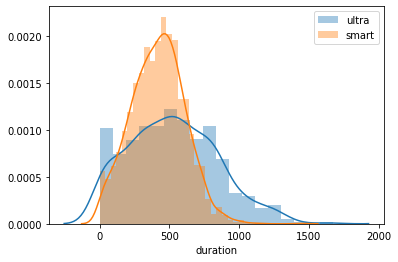

In [25]:
# вывод таблицы с показателями среднего, дисперсии и стандартного отклонения
for tariff in data['tariff'].unique():
    # вытащим из таблицы все пары пользователь+месяц для указанного тарифа
    report = data.query('tariff == @tariff')
    # для указанных параметров рассчитаем статистики методом describe(), дисперсию вычислим как квадрат стандартоно отклонения
    report_1 = report[['duration', 'mb_used', 'messages']].describe().T
    report_1['var'] = report_1['std']**2
    display(report_1.style.format('{:.2f}'))
    # вывод гистограммы по длительности звонков по тарифам smart и ультра
    sns.distplot(report['duration'], label = tariff)
    plt.legend();
    

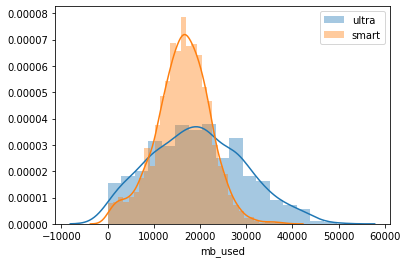

In [26]:
# вывод гистограммы по интернет-трафику
for tariff in data['tariff'].unique():
    report = data.query('tariff == @tariff')
    sns.distplot(report['mb_used'], label = tariff)
    plt.legend();

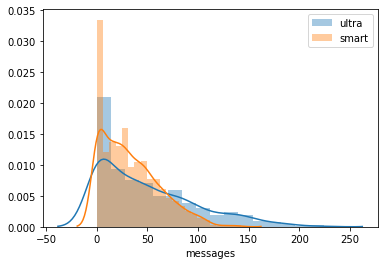

In [27]:
# вывод гистограммы по отправленным сообщениям
for tariff in data['tariff'].unique():
    report = data.query('tariff == @tariff')
    sns.distplot(report['messages'], label = tariff)
    plt.legend();

Проведя анализ, мы увидели, что пользователи тарифа "Ультра" в среднем используют 497 минут разговоров в месяц, почти 19 Гб интернета и отпрвляют в среднем 49 сообщений в месяц.
Пользователи тарифа "Смарт" в среднем говорят чуть меньше - 394 минуты, интернет-трафик также чуть меньше - 16 Гб и количество сообщений в месяц также немного меньше - 33 смс.
Показатели дисперсии для каждого из параметров (длительность звонков, трафик и сообщения) для тарифа "Ультра" выше, чем для тарифа "Смарт", это означает, что эти данные сильнее "размазаны" вокруг среднего значения, более вариативны, т.е. некоторые пользователи тарифа "Ультра"склонны дольше разговаривать, использовать больше интернет-трафика и слать больше смс.
Значения данных параметров для тарифа "Смарт" более плотно распределены вокруг средних зачений, т.е. не много пользователей склонно использовать больше звонков, трафика и смс.

## Проверка гипотез

Нам нужно выяснить различается ли средняя выручка пользователей тарифов «Ультра» и «Смарт» и средняя выручка пользователей из Москвы отличается ли от выручки пользователей из других регионов. Сформулируем гипотезы:

Для средней выручки в зависимости от тарифа

**Нулевая гипотеза** - средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт»;

**Альтернативная гипотеза** - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Также для выручки пользователей по городам.

**Нулевая гипотеза** - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов;

**Альтернативная гипотеза** - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотез проведем t-тесты, полученные значения p-value позволят сделать выводы о том, верны ли наши гипотезы.

In [28]:
# выделяем данные по выручке только по тарифу smart и отдельно по тарифу ultra
revenue_smart = data.query('tariff == "smart"')['revenue']
revenue_ultra = data.query('tariff == "ultra"')['revenue']
# критический уровень статистической значимости возьмем равным 5%
alpha = 0.05
# запуск t-теста
results = st.ttest_ind(revenue_smart, revenue_ultra, equal_var = True)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не отвергаем')

p-значение:  8.081909555489933e-161
Отвергаем нулевую гипотезу


In [29]:
# вывод среднего значения выручки для тарифа smart
revenue_smart.mean()

1289.6417040358745

In [30]:
# вывод среднего значения выручки для тарифа ultra
revenue_ultra.mean()

2070.030425963489

**В результате выполнения t-теста мы получили значение p-value меньше, чем выбранный уровень статистической значимости, поэтому нулевую гипотезу мы отвергаем и принимаем альтернативную гипотезу, что средние зачения выручки для тарифов «Ультра» и «Смарт» различаются.**

In [31]:
# вытаскиваем данные по Москве и отдельно по всем остальным регионам
rev_msk = data.query('city == "Москва"')['revenue']
rev_other = data.query('city != "Москва"')['revenue']
# критический уровень статистической значимости возьмем равным 5%
alpha = 0.05
# запуск t-теста
results = st.ttest_ind(rev_msk, rev_other, equal_var = True)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не отвергаем')


p-значение:  0.5400751614511182
Нулевую гипотезу не отвергаем


**В результате выполнения t-теста мы получили значение p-value больше, чем выбранный уровень статистической значимости, поэтому нулевую гипотезу мы оставляем и можем говорить, что средние выручки по нашим тарифам по Москве и другим регионам не различаются.**

In [32]:
# вывод среднего значения выручки по Москве
rev_msk.mean()

1546.7135842880523

In [33]:
# вывод среднего значения выручки по другим регионам
rev_other.mean()


1524.7251439539348

## Общий вывод

Перед проведением исследования тарифов для телеком-компании потребовалась предобработка имеющихся данных - был преобразован тип данных.

Были рассчитаны и изучены следующие параметры для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Анализ показал:
- Пользователи тарифа **"Ультра"** в среднем используют 497 минут разговоров в месяц, почти 19 Гб интернета и отпрвляют в среднем 49 сообщений в месяц;
- Пользователи тарифа **"Смарт"** в среднем говорят чуть меньше - 394 минуты, интернет-трафик также чуть меньше - 16 Гб и количество сообщений в месяц также немного меньше - 33 смс.
- Показатели дисперсии для каждого из параметров (длительность звонков, трафик и сообщения) для тарифа "Ультра" выше, чем для тарифа "Смарт", это означает, что эти данные сильнее "размазаны" вокруг среднего значения и более вариативны, т.е. некоторые пользователи тарифа "Ультра"склонны дольше разговаривать, использовать больше интернет-трафика и слать больше смс. Значения данных параметров для тарифа "Смарт" более плотно распределены вокруг средних зачений, т.е. не много пользователей склонно использовать больше звонков, трафика и смс.

Были проверены 2 гипотезы:
1) Средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт»;

2) Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

Первая гипотеза не подтвердилась, выручка пользователей тарифа «Ультра» отличается от средней выручки пользователей тарифа «Смарт» и рассчет среднего значения показал, что средняя выручка по тарифу "Ультра" выше на 65% и составляет 2070 руб.
А вот вторая гипотеза подтвердилась, средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Таким образом, тариф "Ультра" выглядит как более перспективный, т.к. средняя выручка на 1 пользователя в нем выше, чем в тарифе "Смарт" и пользователи используют больше минут разговора, больше расходуют интернет-трафик и больше смс, чем в тарифе "Смарт".